In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

In [29]:
#Load the dataset
df = pd.read_csv(r'/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

**clean the Data**

In [30]:
#1- check if there is null values of white Space
print(df.isnull().values.any())
# Delete all rows with column 'TotalCharges' that has whitespace
indexWhitespace = df[df.applymap(lambda x: str(x).isspace()).any(axis=1)].index
df.drop(indexWhitespace, inplace=True)

# Another way to drops white space
#indexAge = df[(df['TotalCharges'] == "") | (df['TotalCharges'] == " ")].index
#df.drop(indexAge, inplace=True)

# Or to fill it with 0
#df['TotalCharges'] = df['TotalCharges'].str.replace(" ",str(0))
#df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])


#2- Removing unimportant columns
df.drop(columns=["customerID","gender"], inplace=True)

#3- Encode categorical values into numerical labels and imputes missing values if any.
# Split the data frame to 2 frames (numarica - categorical)
num_data=df.select_dtypes(["int64","float64"])
cat_data=df.select_dtypes(["object"])

for col in cat_data:
    le = LabelEncoder()
     # Fit and transform the values in the current column using LabelEncoder
    cat_data[col]=le.fit_transform(cat_data[col])

#Concatenate numerical and categorical dataframes
df = pd.concat([num_data,cat_data], axis=1 )
print(df.info())

#4- Change all the values datatype info float
df=df.astype(float)
print(df.head(10))

#5- Outlier Detection and Removal using the IQR Method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Remove outliers
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

#6- Normalization (scale the data between 0 and 1).
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(x_scaled, columns = df.columns)
print(df.head(10))
print("""----""")
#df = pd.DataFrame(scalar.fit_transform(df), columns = df.columns)


False
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7032 non-null   int64  
 1   tenure            7032 non-null   int64  
 2   MonthlyCharges    7032 non-null   float64
 3   Partner           7032 non-null   int64  
 4   Dependents        7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int64  

**SVM model Training and Testing**

In [31]:
#split the data into train and test
Y = df["Churn"]
X = df.drop('Churn', axis=1)
# Splitting the data into train and test sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

from sklearn.svm import SVC
svm_classifier= SVC(kernel='linear', C=1.0, random_state=42) #Instantiate the SVM classifier

# Fit the model
svm_classifier.fit(x_train, y_train)

# Predictions on the test set
y_pred = svm_classifier.predict(x_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import classification_report
print("SVM performance:" , classification_report(y_test, y_pred))

Accuracy: 0.8200626959247649
SVM performance:               precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      1204
         1.0       0.68      0.50      0.57       391

    accuracy                           0.82      1595
   macro avg       0.77      0.71      0.73      1595
weighted avg       0.81      0.82      0.81      1595



**Plot the decision boundary**

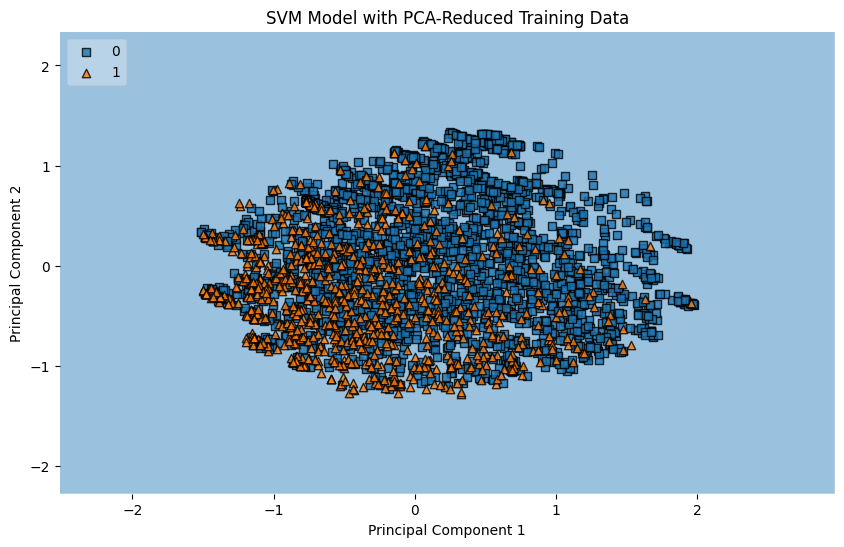

In [32]:
from mlxtend.plotting import plot_decision_regions
# Ensure y_train and y_test are numpy arrays
y_train_array = y_train.astype(int).values
y_test_array = y_test.astype(int).values

# Apply PCA to reduce x_train to 2 components
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

# Transform x_test using the same PCA transformation
x_test_pca = pca.transform(x_test)

# fit the SVM classifier
svm_classifier.fit(x_train_pca, y_train_array)

# Plot the decision regions for the training data
plt.figure(figsize=(10, 6))
plot_decision_regions(X=x_train_pca, y=y_train_array, clf=svm_classifier, legend=2)
plt.title("SVM Model with PCA-Reduced Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

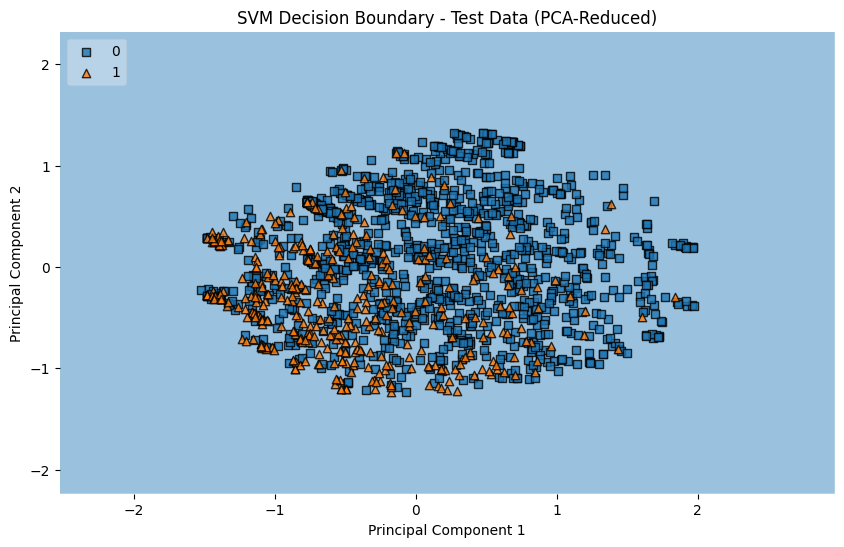

In [33]:
# Plot the decision boundary for the test data
plt.figure(figsize=(10, 6))
plot_decision_regions(X=x_test_pca, y=y_test_array, clf=svm_classifier, legend=2)
plt.title("SVM Decision Boundary - Test Data (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

**Use grid search to find the best hyperparameters**

In [34]:
# Define the parameter grid
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' and 'poly' kernels
}

# Instantiate the SVM classifier
#svm_classifier = SVC(random_state=42)
# Create GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predictions on the test set using the best model
y_pred = best_model.predict(x_test)

# Generate classification report
report = classification_report(y_test, y_pred)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=auto

In [35]:
#################################################

In [36]:
# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.89      1204
         1.0       0.71      0.42      0.53       391

    accuracy                           0.82      1595
   macro avg       0.77      0.68      0.71      1595
weighted avg       0.80      0.82      0.80      1595



In [37]:
svm_classifier= SVC( C= 10, gamma= 'auto', kernel= 'rbf', random_state=42) #Used the best parameters
svm_classifier.fit(x_train_pca, y_train_array)

SVC(C=10, gamma='auto', random_state=42)

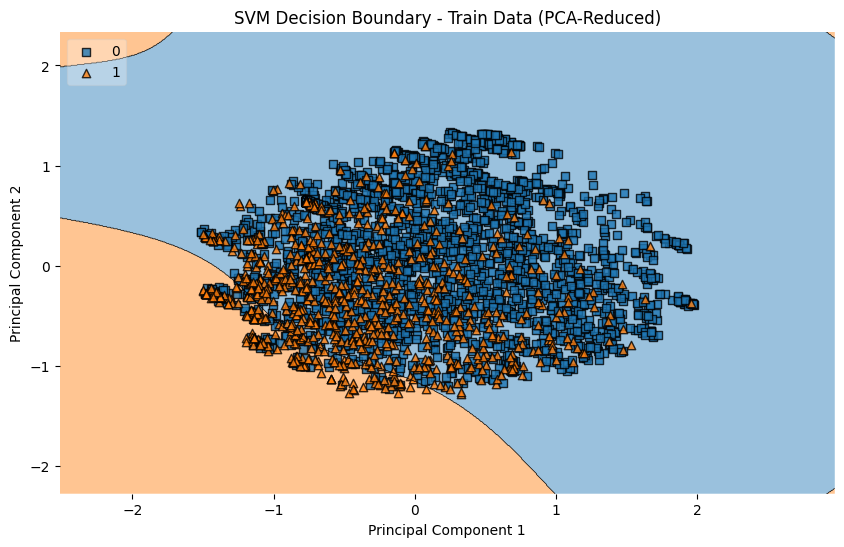

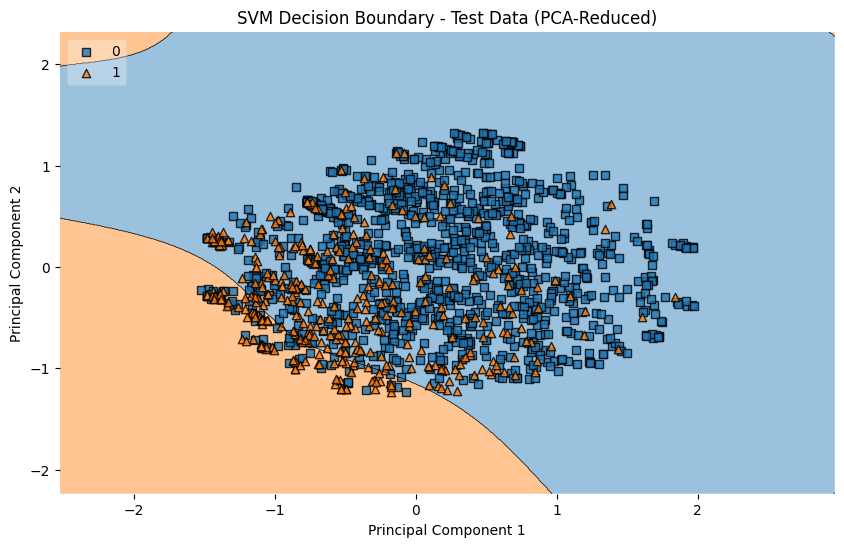

In [46]:

# Plot the decision boundary for the test data
plt.figure(figsize=(10, 6))
#train plot
plot_decision_regions(X=x_train_pca, y=y_train_array, clf=svm_classifier, legend=2)
plt.title("SVM Decision Boundary - Train Data (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

#test plot
plt.figure(figsize=(10, 6))
plot_decision_regions(X=x_test_pca, y=y_test_array, clf=svm_classifier, legend=2)
plt.title("SVM Decision Boundary - Test Data (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()